<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Autoregressive model - AR(p): Foot Traffic Forecast </font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/lehre.html">Gernot Heisenberg</a>
* Date:   10.03.2025

<img src="./images/AR_model.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning how to implement and apply your second statistical model, an Autoregressive model of order p AR(p).

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. now do something
    * subtask 1
    * subtask 2
5. ...
-----------------------------------------------------------------------------------

## 6.0 Module import

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 6.1 Data loading & visualization

In [2]:
# load the data
df = pd.read_csv('./data/foot_traffic.csv')

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


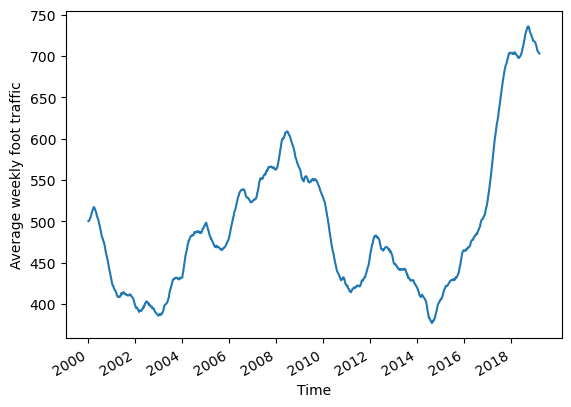

In [3]:
# plot the data
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()

## 6.2 Augmented Dickey-Fuller test

In [4]:
# conducting the Augmented Dickey-Fuller test to check stationarity
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240796
p-value: 0.6838808917896169


In [5]:
# differencing the time series
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

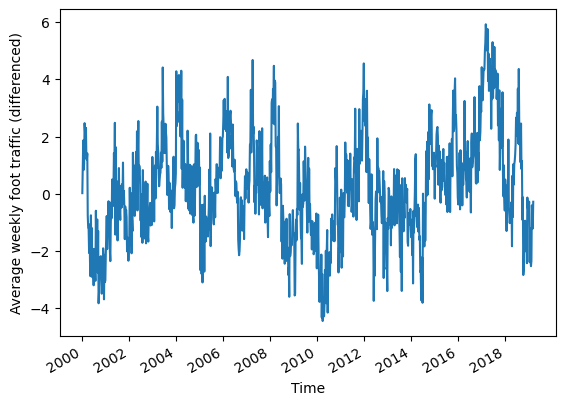

In [6]:
# plot the result
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()

In [7]:
# print results
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422036
p-value: 6.3693176547815e-06


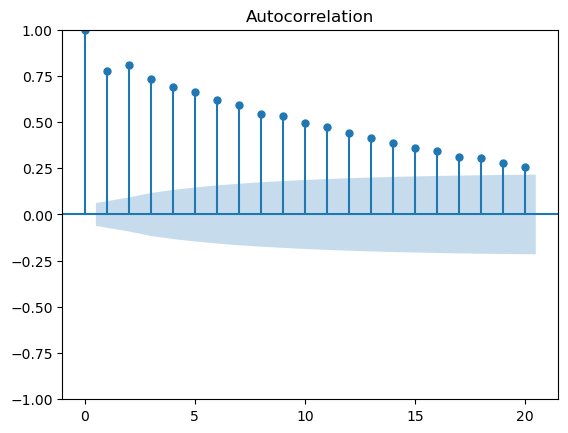

In [8]:
# investigate autocorrelation function
plot_acf(foot_traffic_diff, lags=20);

#### Results so far:
You probably have come to the conclusion before the analysis already, that the presence of a trend over time means that the series is likely not stationary.
After applying a transformation (1st order differencing) it became stationary, however. Then we plotted the ACF. Nwo, you can see that not only is there autocorrelation, but the ACF plot will have a slowly decaying trend.
This is indicative of an autoregressive process of order p, also denoted as AR(p).
So let's proceed and see what we can do now.

## 6.3 Prepare forecasting the foot traffic with an autoregessive AR model or order p - AR(p)

Before we start, let's get used to using the partial autocorrelation function. For this purpose, let#s create an artificial AR(2) process using the ARMA function from the statsmodels lib. 

In [9]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0]) # no MA needed
ar2 = np.array([1, -0.33, -0.50]) # AR needed, set the coefficients

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

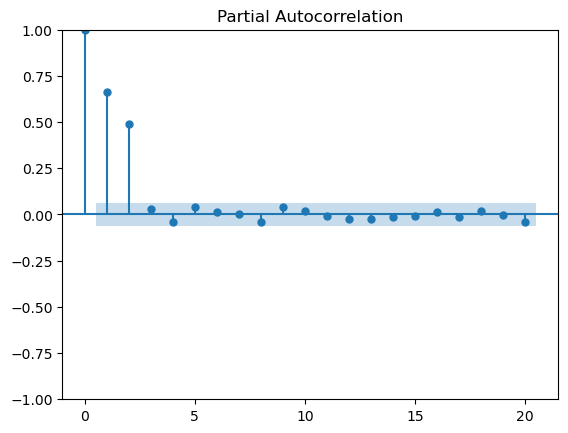

In [10]:
# Plot the PACF now
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(AR2_process, lags=20);

here from the PACF chart we can see clearly that after lag 2, the partial autocorrelation coefficients are not significantly different from 0. Therefore, we can identify the order of a stationary AR(p=2) model using the PACF plot.

#### Apply the same for the real data

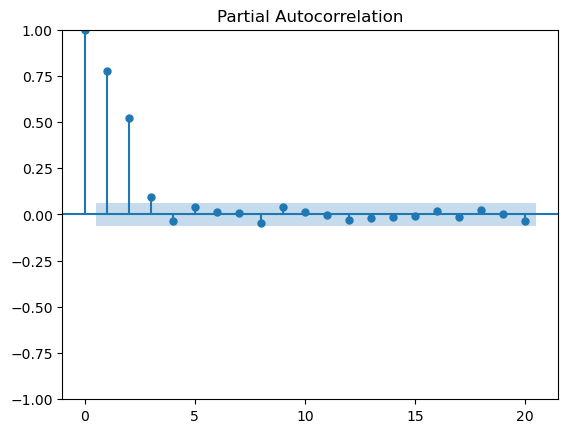

In [11]:
plot_pacf(foot_traffic_diff, lags=20);

here also, we can see the the model order p = 3 before the coefficients are not significantly different from 0.

#### Now, prepare the data for forecasting and visualize both data splits (raw as well as differenced)

In [12]:
# split data into training and test sets
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


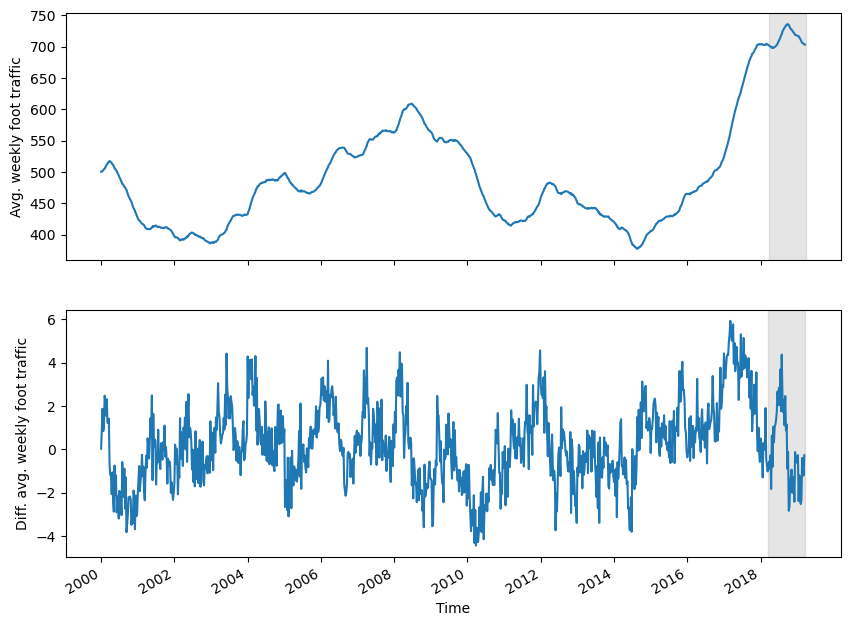

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# plot original foot traffic data
ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

# plot differenced foot traffic data
ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()

Since your objective is to forecast next week’s average foot traffic at the retail store, perform rolling forecasts over your test set. 
Remember, your data was recorded weekly, so predicting the next timestep means you are forecasting next week’s average foot traffic.

NOTE 1: do not forget implementing the baseline models ;-) <br>
NOTE 2: Remember you are working with the differenced series, so your predictions are also differenced values.

In [14]:
# define the rolling forecast function
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    # baseline model 1
    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    # baseline model 2
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    # autoregressive model of order AR(p=3)
    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0)) # here the order is specified. Notice the position of p vs q from the MA model.
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

#### Perform the forecasting

In [15]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 # Since we wish to predict the next timestep only, our window is 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


#### Visualization of the three predictions
Now we can visualize our predictions against the observed values in the test set. 
NOTE, that we are still working with the differenced dataset, so our predictions are also differenced values.

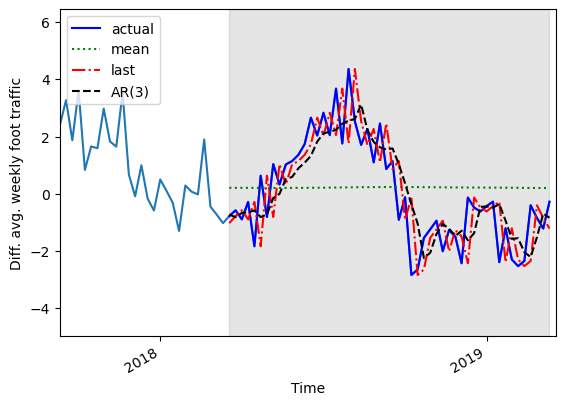

In [16]:
# visualize results
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()

## 6.4 Evaluating the forecasting accuracy

In [17]:
# calculate the Mean Squared Error (MSE) for each forecasting method
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.924247916270599


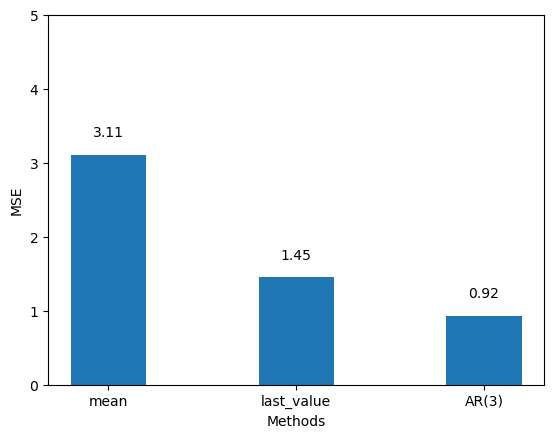

In [18]:
# plot the MSE
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

#### Reverse the differencing to get actual predictions for the original series and visualize it.

In [19]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

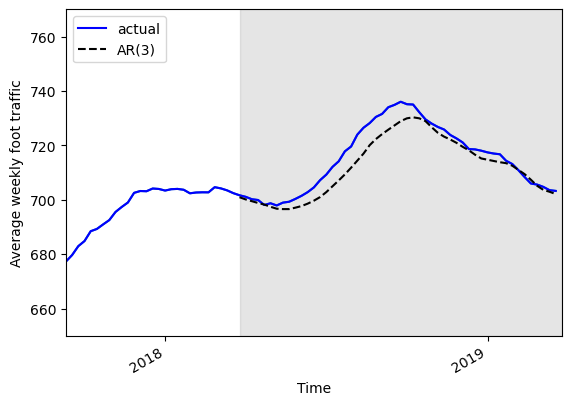

In [20]:
# plot final forecast
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()

In [24]:
#### Evaluate the absolute mean error again

In [25]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print('mae_AR(3)_undiff =',mae_AR_undiff)

mae_AR(3)_undiff = 3.478033556432763


This means that our predictions are off by 3.45 people on average, either above or below the actual value for the week’s foot traffic (not bad, right). 
Note that we report the MAE because it has a simple business meaning that is easy to understand and interpret.